In [3]:
!pip install tensorflow-quantum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.5 MB 7.7 MB/s 
     |████████████████████████████████| 100 kB 10.6 MB/s 
     |████████████████████████████████| 90 kB 6.3 MB/s 
     |████████████████████████████████| 6.1 MB 39.9 MB/s 
     |████████████████████████████████| 541 kB 30.9 MB/s 
     |████████████████████████████████| 1.8 MB 41.2 MB/s 
     |████████████████████████████████| 90 kB 9.3 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.8 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 92 kB 1.2 M

In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq
from tensorflow.keras.layers import Dense, Multiply, Add, Activation, concatenate

import cirq
import sympy
import numpy as np

import pandas as pd
import warnings

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import math


In [5]:
def circuit_builder(n_qubits, n_pqc_layers, tag=''):
  
  assert n_qubits>1, "in order to achieve entanglement, please build the circuit with at least 2 qubits"
  qbs=cirq.LineQubit.range(n_qubits)
  ops=[cirq.Z(qbs[qb]) for qb in range(n_qubits)]

  #define the symmbols for the encoding 
  enc_string=''
  for q in range(n_qubits):
    usage='ENC'
    space=' '
    enc_string+=tag+usage+'Qub'+str(q)+space

  enc_symbols = sympy.symbols(enc_string)

  #define the symmbols for the pqc
  layers=[str(i) for i in range(n_pqc_layers)]
  rotations=['Z','Y','X']
  layers_list=[]
  usage='PQC'
  l_symbols=[]
  for layer in layers:
    l_layer=[]
    for q in range(n_qubits):
      l_qub=[]
      for rot in rotations:
        symb = tag+usage+'Layer'+layer+'Qub'+str(q)+'Rot'+rot
        l_qub.append(symb)
      l_layer.append(l_qub)
    l_symbols.append(l_layer)
  pqc_symbols=sympy.symbols(l_symbols)
  
  #create istance of the circuit and append rotations for encoding with enc_symbols as parameters
  circuit = cirq.Circuit()
  circuit.append([cirq.rx(enc_symbols[qb]).on(qbs[qb]) for qb in range(n_qubits)])

  #append pqc layers
  for layer in range(n_pqc_layers):
    for rot in rotations:
      if rot=='Z':
        circuit.append(cirq.Moment([
                        cirq.rz(pqc_symbols[layer][qb][0]).on(qbs[qb]) for qb in range(n_qubits)])
                    )
      elif rot=='Y':
        circuit.append(cirq.Moment([
                        cirq.ry(pqc_symbols[layer][qb][1]).on(qbs[qb]) for qb in range(n_qubits)])
                    )
      elif rot=='X':
        circuit.append(cirq.Moment([
                        cirq.rx(pqc_symbols[layer][qb][2]).on(qbs[qb]) for qb in range(n_qubits)])
                    )


    for qb in range(n_qubits-1):
      circuit.append(cirq.Moment([
                        cirq.CNOT(qbs[qb],qbs[qb+1]) ])
                    )
    if (n_qubits != 2):
      circuit.append( cirq.Moment([
                                   cirq.CNOT(qbs[n_qubits-1],qbs[0]) ])
                      )
  pqc_symbols=[symb for lay_list in pqc_symbols for qub_list in lay_list for symb in qub_list]
  circuit_spec={"enc_symb":list(enc_symbols) ,"pqc_symb":pqc_symbols, "ops": ops, "n_qubits":n_qubits,  "n_pqc_layers":n_pqc_layers}

  return circuit, circuit_spec


class QuantumLayer1D(tf.keras.layers.Layer):

  def __init__(self, circuit, circuit_spec, max_batch_size=64, name='quantum_layer_1d'):
  
    super(QuantumLayer1D,self).__init__()

    self.circuit=circuit
    self.n_qubits=circuit_spec["n_qubits"]
    self.enc_symbols = circuit_spec["enc_symb"]
    self.pqc_symbols = circuit_spec["pqc_symb"]
    self.all_symbols = self.enc_symbols + self.pqc_symbols
    self.ops = circuit_spec["ops"]
    self.max_batch_size=max_batch_size
    
    
    init=tf.random_normal_initializer()
    self.pqc_params=tf.Variable(initial_value=init(shape=(1,len(self.pqc_symbols)), 
                                                        dtype="float32"),trainable=True)
    
    self.expect_layer=tfq.layers.Expectation()

    self.tens_circuit=tfq.convert_to_tensor([self.circuit for _ in range(self.max_batch_size)])

    warnings.warn(
    f"\nNOTE: You are using an istance of the QuantumLayer1D class."
    f"\nThe maximum batch size dimension allowed in training/predicting for a model containing a "
    f"QuantumLayer2D is {self.max_batch_size}."
    
    f"\nWhen predicting outputs, please call the method call_in_batches of the model with a"
    f" batch_size value less than or equal to {self.max_batch_size}."

    f"\nIf default call method is used when predicting and the batch size of the datas "
    f"is greater than {self.max_batch_size}, an Error will be raised."

    f"\nIf a bigger batch size is desired, please consider to increase the value of "
    f"max_batch_size arg in your QuantumLayer1D: {name}.")

  def call(self, inputs):

    # inputs: classical output of a previous layer (i.e. classical data to encode)
    # or directly the classical input for the model


    batch_size = tf.gather(tf.shape(inputs), 0)
    pqc_params = tf.tile(self.pqc_params, [batch_size, 1])  
    joined_params = tf.concat([inputs, pqc_params], -1)    
    
    return self.expect_layer(self.tens_circuit[:batch_size],  
                                    operators=self.ops,
                                    symbol_names=self.all_symbols,
                                    symbol_values=joined_params)


################################################# QLSTM ########################    
    

class QLSTM(tf.keras.layers.Layer):
    
  def __init__(self, qubits, pqc_layers, return_sequence=False, mask_value=None, states_initializer=None, name='qlstm'):
  
    super(QLSTM, self).__init__(name=name)
    self.return_sequence=return_sequence
    self.mask_value=mask_value
    
    #build circuit and get qubit
    circuit, circuit_spec= circuit_builder(qubits,pqc_layers)
    self.qubits=circuit_spec["n_qubits"]


    #forget gate init
    self.wrapper_forget = Dense(self.qubits)
    self.quant_forget = QuantumLayer1D(circuit, circuit_spec)
    
    #input gate init
    self.wrapper_input = Dense(self.qubits)
    self.quant_input = QuantumLayer1D(circuit, circuit_spec)

    #candidate gate init
    self.wrapper_candidate = Dense(self.qubits)
    self.quant_candidate = QuantumLayer1D(circuit, circuit_spec)

    #output gate init
    self.wrapper_output = Dense(self.qubits)
    self.quant_output = QuantumLayer1D(circuit, circuit_spec)


    #set the initializer for state h and c

    if states_initializer is None:
        self.states_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    else:
        self.states_initializer=states_initializer
  
    
  def call(self, inputs): 
    

    #random initialization of state h and state c 
    batch_size=tf.shape(inputs)[0]
    self.state_h = self.states_initializer(shape=(batch_size,self.qubits)) 
    self.state_c = self.states_initializer(shape=(batch_size,self.qubits))
    
    #output_sequence = []
    
    for t in range(inputs.shape[1]):
        
      x_t = inputs[:,t,:]
      
      if self.mask_value is not None:
        state_h_copy, state_c_copy = tf.identity(self.state_h), tf.identity(self.state_c)
        mask = (x_t != 0.)
        mask = tf.reduce_any(mask, axis=1)
        mask = tf.transpose(tf.stack([mask]*self.qubits),perm=[1,0])
      
      concat_inputs = concatenate([self.state_h,x_t],axis=1)
      
      #forwad computations for gates
      forget = self.wrapper_forget(concat_inputs)
      forget = self.quant_forget(forget)
      forget = tf.math.sigmoid(forget)
      
      input_ = self.wrapper_input(concat_inputs)
      input_ = self.quant_input(input_)
      input_ = tf.math.sigmoid(input_)
      
      candidate = self.wrapper_candidate(concat_inputs)
      candidate = self.quant_candidate(candidate)
      candidate = tf.math.tanh(candidate)
      
      output = self.wrapper_output(concat_inputs)
      output = self.quant_output(output)
      output = tf.math.sigmoid(output)
      
      #execute pointwise operatios between gates
      self.state_c = Multiply()([forget,self.state_c])
      candidate_accepted = Multiply()([input_,candidate])
      self.state_c = Add()([self.state_c,candidate_accepted])
      state_c_passed_in_tanh = Activation('tanh')(self.state_c)
      self.state_h = Multiply()([state_c_passed_in_tanh,output])
      
      
      if self.mask_value is not None:
        self.state_h = tf.where(mask,self.state_h,state_h_copy)
        self.state_c = tf.where(mask,self.state_c,state_c_copy)

      #append state h to output sequence
      #output_sequence.append(self.state_h)
    
    if self.return_sequence:
        #output_sequence=tf.stack(output_sequence,axis=1)
        print(f"WARNING: return_sequence not yet implemented.\n"
        f"Only returning states.")
        return self.state_h, self.state_c #, output_sequence
    else:
        return self.state_h, self.state_c

################################################# LSTM #########################      


class _LSTM_(tf.keras.layers.Layer):
    
  def __init__(self, hidden_dim, return_sequence=False, mask_value=None, states_initializer=None, name='lstm'):
  
    super(_LSTM_, self).__init__(name=name)
    self.return_sequence=return_sequence
    self.mask_value=mask_value
    
    self.hidden_dim=hidden_dim

    #forget gate init
    self.forget_gate = Dense(hidden_dim)
    
    #input gate init
    self.input_gate = Dense(hidden_dim)

    #candidate gate init
    self.candidate_gate = Dense(hidden_dim)

    #output gate init
    self.output_gate = Dense(hidden_dim)

    #set the initializer for state h and c

    if states_initializer is None:
        self.states_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    else:
        self.states_initializer=states_initializer
  
    
  def call(self, inputs): 
    

    #random initialization of state h and state c 
    batch_size=tf.shape(inputs)[0]
    self.state_h = self.states_initializer(shape=(batch_size,self.hidden_dim)) 
    self.state_c = self.states_initializer(shape=(batch_size,self.hidden_dim))
    
    #output_sequence = []
    
    for t in range(inputs.shape[1]):
        
      x_t = inputs[:,t,:]
      
      if self.mask_value is not None:
        state_h_copy, state_c_copy = tf.identity(self.state_h), tf.identity(self.state_c)
        mask = (x_t != 0.)
        mask = tf.reduce_any(mask, axis=1)
        mask = tf.transpose(tf.stack([mask]*self.hidden_dim),perm=[1,0])
      
      concat_inputs = concatenate([self.state_h,x_t],axis=1)
      
      #forwad computations for gates
      forget = self.forget_gate(concat_inputs)
      forget = tf.math.sigmoid(forget)
      
      input_ = self.input_gate(concat_inputs)
      input_ = tf.math.sigmoid(input_)
      
      candidate = self.candidate_gate(concat_inputs)
      candidate = tf.math.tanh(candidate)
      
      output = self.output_gate(concat_inputs)
      output = tf.math.sigmoid(output)
      
      #execute pointwise operatios between gates
      self.state_c = Multiply()([forget,self.state_c])
      candidate_accepted = Multiply()([input_,candidate])
      self.state_c = Add()([self.state_c,candidate_accepted])
      state_c_passed_in_tanh = Activation('tanh')(self.state_c)
      self.state_h = Multiply()([state_c_passed_in_tanh,output])
      
      
      if self.mask_value is not None:
        self.state_h = tf.where(mask,self.state_h,state_h_copy)
        self.state_c = tf.where(mask,self.state_c,state_c_copy)

      #append state h to output sequence
      #output_sequence.append(self.state_h)
    
    if self.return_sequence:
        #output_sequence=tf.stack(output_sequence,axis=1)
        print(f"WARNING: return_sequence not yet implemented.\n"
        f"Only returning states.")
        return self.state_h, self.state_c #, output_sequence
    else:
        return self.state_h, self.state_c

################################################## Tracking callback ###########

#callback for tracking progress on Drive
class Tracking(tf.keras.callbacks.Callback):
  
  def __init__(self,metrics,save_folder,exp_name,model):
    self.save_folder=save_folder
    self.model=model
    self.exp_name=exp_name
    self.tracking={"loss":[], "val_loss":[]}
    for newkey in metrics:
      self.tracking[newkey]=[]
      self.tracking['val_'+newkey]=[]

  def on_epoch_end(self, epoch, logs=None):
    keys = list(logs.keys())
    for key in keys:
      self.tracking[key].append(logs[key])
  
  def on_train_end(self, logs=None):
    tracking_df=pd.DataFrame.from_dict(self.tracking, orient='columns')
    path=self.save_folder+self.exp_name+'_history.csv'
    tracking_df.to_csv(path,index=False,encoding = 'utf-8-sig')
    path=self.save_folder+self.exp_name+'_model'
    #self.model.save(path)





In [4]:
#Model Classes

class Q_Model(tf.keras.Model):

  def __init__(self, qubits, pqc_layers, dense_block=[16,8], mask_value=None):
    
    super(Q_Model, self).__init__()
    
    self.qlstm = QLSTM(qubits=qubits, pqc_layers=pqc_layers, mask_value=mask_value)
    self.dense=[tf.keras.layers.Dense(neurons,activation='relu') for neurons in dense_block]
    self.dense_out = tf.keras.layers.Dense(1)

  def call(self,inp):

    out,_ = self.qlstm(inp)
    for layer in self.dense:
      out = layer(out)
    out = self.dense_out(out)

    return out

  def call_in_batches(self,inputs,batch_size):

    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    batches = dataset.batch(batch_size=batch_size)
    batches_outuput=[self.call(batch) for batch in batches]
        
    return tf.concat(batches_outuput,axis=0)

class _Model_(tf.keras.Model):

  def __init__(self, hidden_dim, dense_block=[16,8], mask_value=None):
    
    super(_Model_, self).__init__()
    
    self.lstm = _LSTM_(hidden_dim=hidden_dim, mask_value=mask_value)
    self.dense=[tf.keras.layers.Dense(neurons,activation='relu') for neurons in dense_block]
    self.dense_out = tf.keras.layers.Dense(1)

  def call(self,inp):

    out,_ = self.lstm(inp)
    for layer in self.dense:
      out = layer(out)
    out = self.dense_out(out)

    return out


DATAS:

In [5]:
def min_max_scaler(df_train,df_test,columns=None,MAX=1,MIN=0):
    
    if columns is None:
        columns = df_train.columns

    for col in columns:
        maximum = df_train.loc[:,col].max()
        minimum = df_train.loc[:,col].min()
        df_train.loc[:,col]=(MAX-MIN)*(df_train.loc[:,col]-maximum)/(maximum-minimum) + MAX
        df_test.loc[:,col]=(MAX-MIN)*(df_test.loc[:,col]-maximum)/(maximum-minimum) + MAX
        
    return df_train, df_test

def make_data(df_input,df_target,n_previous_days):   
    dates=df_input.index.date
    dates=np.unique(dates)
    
    inputs=[]
    outputs=[]
    
    for i in range(dates.shape[0]-n_previous_days):
        
        date0=dates[i].strftime('%Y-%m-%d')
        date1=dates[i+n_previous_days].strftime('%Y-%m-%d')
        
        date1_open_GHR = date1+ ' 11:00:00'
        date1_close_GHR = date1+ ' 14:00:00'
        
        max_ghr = df_target.loc[date1_open_GHR:date1_close_GHR].max()
        
        if math.isnan(max_ghr):
            pass
        
        else:
            
            outputs.append(max_ghr)
            
            date1_till_9 =  date1 +' 09:00:00'
            in_seq = df_input.loc[date0:date1_till_9].to_numpy()

            inputs.append(in_seq)
        
    return tf.constant(np.stack(inputs),dtype='float32'), tf.constant(np.stack(outputs).reshape(-1,1),dtype='float32')

df = pd.read_csv('/content/drive/MyDrive/TESI/3052-Site_Environment-DG_Weather_Station_04-2016_05-2022.csv')
df.Timestamp = df.Timestamp.astype(np.datetime64) #set 'Timestamp' to np.datetime type
df = df.set_index('Timestamp') # set 'Timestamp' column as index
df = df.resample('H').first() #Fill all the missing timesteps with Nan 
df = df.drop(columns=['Hail_Accumulation','Temperature_Probe_1','Temperature_Probe_2','Max_Wind_Speed','Pyranometer_1'])

df=df.loc[(df.index > '2016-05-17 23:00:00')]

df.interpolate()

unique_dates = np.unique(df.index.date)
split_value=0.8

split_date = unique_dates[int(split_value*unique_dates.shape[0])]
split_date = np.datetime64(split_date)

df_train = df.loc[:(split_date-1).item().strftime('%Y-%m-%d')]
df_test = df.loc[(split_date).item().strftime('%Y-%m-%d'):]

df_train_target=df_train['Global_Horizontal_Radiation'].copy(deep=True)
df_test_target=df_test['Global_Horizontal_Radiation'].copy(deep=True)

df_train_input , df_test_input = min_max_scaler(df_train, df_test)
MASK_VALUE=0.
df_train_input = df_train_input.fillna(MASK_VALUE)
df_test_input = df_test_input.fillna(MASK_VALUE)

inputs_train,outputs_train=make_data(df_train_input,df_train_target,2)
inputs_test,outputs_test=make_data(df_test_input,df_test_target,2)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [6]:
#tracking info
metrics=['mean_squared_error','mean_absolute_error', 'mean_absolute_percentage_error']
save_fold='/content/drive/MyDrive/TESI/LSTM_vs_QLSTM/'

### CLASSIC LSTM (SMALL HIDDEN DIM)

In [9]:

model_0=_Model_(hidden_dim=8)

#optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.001)

#early stopping callback
earstop=tf.keras.callbacks.EarlyStopping(patience=20,
    restore_best_weights=True)

#tracking callback
exp_name_0='classical_lstm_small_hidden_dim'
tracking = Tracking(metrics,save_fold,exp_name_0,model_0)

model_0.compile(loss='log_cosh', optimizer=opt, metrics=metrics)

In [10]:
%%time
model_0.fit(inputs_train,outputs_train,batch_size=32,validation_split=0.2,epochs=200,callbacks=[tracking,earstop])

Epoch 1/200
43/43 [==============================] - 33s 176ms/step - loss: 881.6298 - mean_squared_error: 814765.3125 - mean_absolute_error: 882.3230 - mean_absolute_percentage_error: 99.9720 - val_loss: 865.6418 - val_mean_squared_error: 787996.8125 - val_mean_absolute_error: 866.3350 - val_mean_absolute_percentage_error: 99.9395
Epoch 2/200
43/43 [==============================] - 3s 70ms/step - loss: 880.8694 - mean_squared_error: 813419.2500 - mean_absolute_error: 881.5623 - mean_absolute_percentage_error: 99.8794 - val_loss: 864.2827 - val_mean_squared_error: 785643.3750 - val_mean_absolute_error: 864.9758 - val_mean_absolute_percentage_error: 99.7706
Epoch 3/200
43/43 [==============================] - 3s 72ms/step - loss: 878.5659 - mean_squared_error: 809359.1875 - mean_absolute_error: 879.2592 - mean_absolute_percentage_error: 99.5983 - val_loss: 861.0004 - val_mean_squared_error: 779980.4375 - val_mean_absolute_error: 861.6935 - val_mean_absolute_percentage_error: 99.3624
Ep

In [11]:
predictions_0=model_0.predict(inputs_test)

**********************************************
TESTING METRICS SCORES:
Log Cosh Error: 65.1
Mean Squared Error:12933
Mean Absolute Error: 65.8
Mean Absolute Percentage Error: 8.43
**********************************************


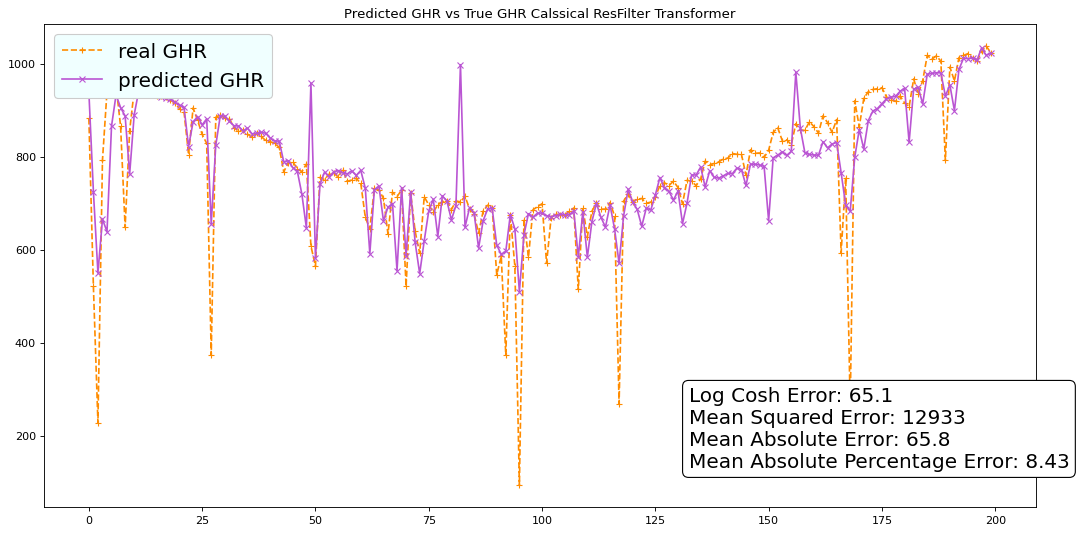

In [13]:
mse=tf.keras.metrics.MeanSquaredError()
mse.update_state(tf.reshape(predictions_0,(-1,)), tf.reshape(outputs_test,(-1,)))

mae= tf.keras.metrics.MeanAbsoluteError()
mae.update_state(tf.reshape(predictions_0,(-1,)), tf.reshape(outputs_test,(-1,)))

mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(tf.reshape(predictions_0,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh = tf.keras.metrics.LogCoshError()
logcosh.update_state(tf.reshape(predictions_0,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh=round(logcosh.result().numpy(),1)
mse=int(round(mse.result().numpy(),0))
mae=round(mae.result().numpy(),1)
mape=round(mape.result().numpy(),2)

print('**********************************************')
print('TESTING METRICS SCORES:')
print("Log Cosh Error: "+str(logcosh))
print("Mean Squared Error:" +str(mse)) 
print("Mean Absolute Error: " +str(mae))
print("Mean Absolute Percentage Error: " +str(mape)) 

print('**********************************************')


fig = figure(figsize=(16, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Predicted GHR vs True GHR LSTM 8 neurons hidden dim')
ax.plot(outputs_test[:200], label='real GHR', color='darkorange',ls='--', marker='+', markersize=6)
ax.plot(predictions_0[:200], label='predicted GHR', color='mediumorchid', marker='x', markersize=6)
ax.legend(framealpha=1.0, facecolor='azure' ,loc="upper left", fontsize=18)


textstr = '\n'.join((
    "Log Cosh Error: "+str(logcosh),
    "Mean Squared Error: " +str(mse),
    "Mean Absolute Error: " +str(mae),
    "Mean Absolute Percentage Error: " +str(mape)))

props = dict(boxstyle='round', facecolor='white', alpha=1,)

# place a text box in upper left in axes coords
ax.text(0.65, 0.250, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

#plt.show()
plt.savefig(save_fold+exp_name_0+'.png')

QUANTUM MODEL 4 QUBIT PER GATE

In [25]:

model_1=Q_Model(qubits=4,pqc_layers=1)

#optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.001)

#early stopping callback
earstop=tf.keras.callbacks.EarlyStopping(patience=20,
    restore_best_weights=True)

#tracking callback
exp_name_1='quantum_lstm_4qubits'
tracking = Tracking(metrics,save_fold,exp_name_1,model_1)

model_1.compile(loss='log_cosh', optimizer=opt, metrics=metrics)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: UserWarning: 
NOTE: You are using an istance of the QuantumLayer1D class.
The maximum batch size dimension allowed in training/predicting for a model containing a QuantumLayer2D is 64.
When predicting outputs, please call the method call_in_batches of the model with a batch_size value less than or equal to 64.
If default call method is used when predicting and the batch size of the datas is greater than 64, an Error will be raised.
If a bigger batch size is desired, please consider to increase the value of max_batch_size arg in your QuantumLayer1D: quantum_layer_1d.


In [ ]:
%%time
model_1.fit(inputs_train,outputs_train,batch_size=32,validation_split=0.2,epochs=200,callbacks=[tracking,earstop])

Epoch 1/200
43/43 [==============================] - 366s 6s/step - loss: 881.2599 - mean_squared_error: 814110.5625 - mean_absolute_error: 881.9529 - mean_absolute_percentage_error: 99.9271 - val_loss: 865.1759 - val_mean_squared_error: 787189.4375 - val_mean_absolute_error: 865.8691 - val_mean_absolute_percentage_error: 99.8816
Epoch 2/200
43/43 [==============================] - 240s 6s/step - loss: 880.4655 - mean_squared_error: 812712.0000 - mean_absolute_error: 881.1586 - mean_absolute_percentage_error: 99.8293 - val_loss: 864.1832 - val_mean_squared_error: 785469.8125 - val_mean_absolute_error: 864.8764 - val_mean_absolute_percentage_error: 99.7584
Epoch 3/200
43/43 [==============================] - 141s 3s/step - loss: 879.1801 - mean_squared_error: 810444.3750 - mean_absolute_error: 879.8730 - mean_absolute_percentage_error: 99.6723 - val_loss: 862.5134 - val_mean_squared_error: 782585.1250 - val_mean_absolute_error: 863.2065 - val_mean_absolute_percentage_error: 99.5509
Epoc

In [ ]:
predictions_1=model_1.call_in_batches(inputs_test,batch_size=32)

In [ ]:
mse=tf.keras.metrics.MeanSquaredError()
mse.update_state(tf.reshape(predictions_1,(-1,)), tf.reshape(outputs_test,(-1,)))

mae= tf.keras.metrics.MeanAbsoluteError()
mae.update_state(tf.reshape(predictions_1,(-1,)), tf.reshape(outputs_test,(-1,)))

mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(tf.reshape(predictions_1,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh = tf.keras.metrics.LogCoshError()
logcosh.update_state(tf.reshape(predictions_1,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh=round(logcosh.result().numpy(),1)
mse=int(round(mse.result().numpy(),0))
mae=round(mae.result().numpy(),1)
mape=round(mape.result().numpy(),2)

print('**********************************************')
print('TESTING METRICS SCORES:')
print("Log Cosh Error: "+str(logcosh))
print("Mean Squared Error:" +str(mse)) 
print("Mean Absolute Error: " +str(mae))
print("Mean Absolute Percentage Error: " +str(mape)) 

print('**********************************************')


fig = figure(figsize=(16, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Predicted GHR vs True GHR QLSTM 4 qubits')
ax.plot(outputs_test[:200], label='real GHR', color='darkorange',ls='--', marker='+', markersize=6)
ax.plot(predictions_1[:200], label='predicted GHR', color='mediumorchid', marker='x', markersize=6)
ax.legend(framealpha=1.0, facecolor='azure' ,loc="upper left", fontsize=18)


textstr = '\n'.join((
    "Log Cosh Error: "+str(logcosh),
    "Mean Squared Error: " +str(mse),
    "Mean Absolute Error: " +str(mae),
    "Mean Absolute Percentage Error: " +str(mape)))

props = dict(boxstyle='round', facecolor='white', alpha=1,)

# place a text box in upper left in axes coords
ax.text(0.65, 0.250, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

#plt.show()
plt.savefig(save_fold+exp_name_1+'.png')

LOSSES COMPARISON

In [ ]:
history_0=pd.read_csv(save_fold+exp_name_0+'_history.csv')
history_1=pd.read_csv(save_fold+exp_name_1+'_history.csv')


loss_0=history_0['loss'].to_numpy()
val_loss_0=history_0['val_loss'].to_numpy()
loss_1=history_1['loss'].to_numpy()
val_loss_1=history_1['val_loss'].to_numpy()


fig=figure(figsize=(16, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('QLSTM 4 qubits vs LSTM 8 neurons hidden dim')

ax.plot(loss_0, label=exp_name_0, c='darkcyan')
ax.plot(val_loss_0, label=exp_name_0, c='darkturquoise', ls='dashdot')

ax.plot(loss_1, label=exp_name_1,  c='maroon' )
ax.plot(val_loss_1, label=exp_name_1, c='firebrick', ls='dashdot')



ax.legend(framealpha=1.0, facecolor='azure' ,loc="upper right", fontsize=18)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('epochs')


plt.savefig(save_fold+'losses_comparison.png')